###Setting up Libraries

In [0]:
%pip install google-cloud-storage
%pip install google-cloud-bigquery  
%pip install db-dtypes

Python interpreter will be restarted.
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.4
    Not uninstalling protobuf at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-978b9be8-0ec5-4343-8e4d-5f194c072931
    Can't uninstall 'protobuf'. No files were found to uninstall.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
%pip list | grep google-cloud-bigquery

google-cloud-bigquery             3.25.0


In [0]:
from google.cloud import storage
import os
from pyspark.sql import SparkSession
import json
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


###Connecting Google Cloud Storage with Databricks

In [0]:
# Copy the JSON key file from DBFS to the /tmp directory on the local filesystem of the driver node
dbutils.fs.cp("dbfs:/FileStore/shared_uploads/aslam1996asad@gmail.com/ccbd_exam_2024_asad_aslam_279ee9138000-2.json", "file:/tmp/ccbd_exam_2024_asad_aslam_279ee9138000-2.json")

# Set the environment variable for authentication
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/tmp/ccbd_exam_2024_asad_aslam_279ee9138000-2.json"


In [0]:
# Initialize the Google Cloud Storage client
client = storage.Client()

In [0]:
# Define your GCS bucket and file details
source_blob_name = 'dataset.csv'
local_temp_file = '/tmp/dataset_Databricks.csv'
destination_file_name = 'dbfs:/FileStore/shared_uploads/aslam1996asad@gmail.com/dataset_Databricks.csv'

bucket_name = 'ccbd-exam-2023-asad-aslam'
bucket = client.get_bucket(bucket_name)

# List objects in the bucket
blobs = bucket.list_blobs()
for blob in blobs:
    print(blob.name)

# Download the file from GCS to local filesystem
blob = bucket.blob(source_blob_name)
blob.download_to_filename(local_temp_file)

print(f"Downloaded {source_blob_name} to {local_temp_file}.")

# Copy the file from the local filesystem to DBFS
dbutils.fs.cp(f"file:{local_temp_file}", destination_file_name)

print(f"Copied {local_temp_file} to {destination_file_name}.")

dataset.csv
queries/query1.csv
queries/query2.csv
queries/query3.csv
queries/query4.csv
queries/query5.csv
Downloaded dataset.csv to /tmp/dataset_Databricks.csv.
Copied /tmp/dataset_Databricks.csv to dbfs:/FileStore/shared_uploads/aslam1996asad@gmail.com/dataset_Databricks.csv.


###Reading CSV file

In [0]:
df = spark.read.csv('dbfs:/FileStore/shared_uploads/aslam1996asad@gmail.com/dataset_Databricks.csv', header=True, inferSchema=True)
df.show()

+-------+------+-------+------------+----------+-----+-----+----------+------------+----------+--------------+------------+------------------+------------------+--------------------+--------------------+--------------------+-----------------+--------------------+------+
|     ID|Gender|Own_car|Own_property|Work_phone|Phone|Email|Unemployed|Num_children|Num_family|Account_length|Total_income|               Age|    Years_employed|         Income_type|      Education_type|       Family_status|     Housing_type|     Occupation_type|Target|
+-------+------+-------+------------+----------+-----+-----+----------+------------+----------+--------------+------------+------------------+------------------+--------------------+--------------------+--------------------+-----------------+--------------------+------+
|5008804|     1|      1|           1|         1|    0|    0|         0|           0|         2|            15|    427500.0| 32.86857361889703|12.435573625741801|             Working|    H

###Queries with Spark SQL

In [0]:
df.createOrReplaceTempView("credit_card")

query1_df = spark.sql("""
    SELECT 
      Occupation_type, 
      AVG(Total_income) AS Avg_Total_Income
    FROM 
       credit_card
    GROUP BY 
      Occupation_type
    ORDER BY 
      Avg_Total_Income DESC
""")
query1_df.show()

query2_df = spark.sql("""
    SELECT 
      Education_type, 
      COUNT(*) AS Num_Unemployed
    FROM 
      credit_card
    WHERE 
      Unemployed = 1
    GROUP BY 
      Education_type
    ORDER BY 
      Num_Unemployed DESC
""")
query2_df.show()

query3_df = spark.sql("""
    SELECT 
      Housing_type, 
      AVG(Num_family) AS Avg_Num_Family
    FROM 
      credit_card
    GROUP BY 
      Housing_type
    ORDER BY 
      Avg_Num_Family DESC
""")
query3_df.show()

query4_df = spark.sql("""
    SELECT 
      CORR(Years_employed, Total_income) AS Correlation
    FROM 
      credit_card
""")
query4_df.show()


query5_df = spark.sql("""
    SELECT 
      COUNT(*) AS Num_People
    FROM 
      credit_card
    WHERE 
      Own_car = 1 AND 
      Total_income > 50000
""")
query5_df.show()



+--------------------+------------------+
|     Occupation_type|  Avg_Total_Income|
+--------------------+------------------+
|            Managers|276028.21611253195|
|            IT staff|          216450.0|
|       Realty agents|         211781.25|
|         Accountants|        203420.175|
|             Drivers| 202070.9470304976|
|            HR staff|195954.54545454544|
|Private service s...|194703.48837209304|
|High skill tech s...|191292.85714285713|
|          Core staff| 186171.1009122007|
|            Laborers|175121.18300464036|
|      Security staff|170572.25274725276|
|         Sales staff|166590.08446298228|
|         Secretaries|165521.73913043478|
|Waiters/barmen staff|          162675.0|
|               Other|162437.49048096192|
|      Medicine staff|160539.55670103093|
|       Cooking staff|147383.16062176166|
|      Cleaning staff|146635.27397260274|
|  Low-skill Laborers|134490.56603773584|
+--------------------+------------------+

+--------------------+-----------

###Queries with Spark Operator

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, corr
spark = SparkSession.builder.appName("CreditCard").getOrCreate()

In [0]:
query1_df = df.groupBy("Occupation_type") \
              .agg(avg("Total_income").alias("Avg_Total_Income")) \
              .orderBy(col("Avg_Total_Income").desc())

query1_df.show()


query2_df = df.filter(col("Unemployed") == 1) \
              .groupBy("Education_type") \
              .agg(count("*").alias("Num_Unemployed")) \
              .orderBy(col("Num_Unemployed").desc())

query2_df.show()

query3_df = df.groupBy("Housing_type") \
              .agg(avg("Num_family").alias("Avg_Num_Family")) \
              .orderBy(col("Avg_Num_Family").desc())

query3_df.show()

query4_df = df.select(corr("Years_employed", "Total_income").alias("Correlation"))

query4_df.show()

query5_df = df.filter((col("Own_car") == 1) & (col("Total_income") > 50000)) \
              .agg(count("*").alias("Num_People"))

query5_df.show()



+--------------------+------------------+
|     Occupation_type|  Avg_Total_Income|
+--------------------+------------------+
|            Managers|276028.21611253195|
|            IT staff|          216450.0|
|       Realty agents|         211781.25|
|         Accountants|        203420.175|
|             Drivers| 202070.9470304976|
|            HR staff|195954.54545454544|
|Private service s...|194703.48837209304|
|High skill tech s...|191292.85714285713|
|          Core staff| 186171.1009122007|
|            Laborers|175121.18300464036|
|      Security staff|170572.25274725276|
|         Sales staff|166590.08446298228|
|         Secretaries|165521.73913043478|
|Waiters/barmen staff|          162675.0|
|               Other|162437.49048096192|
|      Medicine staff|160539.55670103093|
|       Cooking staff|147383.16062176166|
|      Cleaning staff|146635.27397260274|
|  Low-skill Laborers|134490.56603773584|
+--------------------+------------------+

+--------------------+-----------

###Queries interfacing with Big Query

In [0]:
from google.cloud import bigquery

# Initialize BigQuery client
client = bigquery.Client.from_service_account_json('/tmp/ccbd_exam_2024_asad_aslam_279ee9138000-2.json')


In [0]:
query1 = """
    SELECT 
      Occupation_type, 
      AVG(Total_income) AS Avg_Total_Income
    FROM 
       `ccbd-exam-2024-asad-aslam.credit_card_dataset.credit_card`
    GROUP BY 
      Occupation_type
    ORDER BY 
      Avg_Total_Income DESC
"""

result1 = client.query(query1).to_dataframe()
print(result1)


/local_disk0/.ephemeral_nfs/envs/pythonEnv-978b9be8-0ec5-4343-8e4d-5f194c072931/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-978b9be8-0ec5-4343-8e4d-5f194c072931/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-978b9be8-0ec5-4343-8e4d-5f194c072931/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >

          Occupation_type  Avg_Total_Income
0                Managers     276028.216113
1                IT staff     216450.000000
2           Realty agents     211781.250000
3             Accountants     203420.175000
4                 Drivers     202070.947030
5                HR staff     195954.545455
6   Private service staff     194703.488372
7   High skill tech staff     191292.857143
8              Core staff     186171.100912
9                Laborers     175121.183005
10         Security staff     170572.252747
11            Sales staff     166590.084463
12            Secretaries     165521.739130
13   Waiters/barmen staff     162675.000000
14                  Other     162437.490481
15         Medicine staff     160539.556701
16          Cooking staff     147383.160622
17         Cleaning staff     146635.273973
18     Low-skill Laborers     134490.566038


In [0]:
query2 = """
    SELECT 
      Education_type, 
      COUNT(*) AS Num_Unemployed
    FROM 
      `ccbd-exam-2024-asad-aslam.credit_card_dataset.credit_card`
    WHERE 
      Unemployed = 1
    GROUP BY 
      Education_type
    ORDER BY 
      Num_Unemployed DESC
"""

result2 = client.query(query2).to_dataframe()
print(result2)


/local_disk0/.ephemeral_nfs/envs/pythonEnv-978b9be8-0ec5-4343-8e4d-5f194c072931/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-978b9be8-0ec5-4343-8e4d-5f194c072931/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-978b9be8-0ec5-4343-8e4d-5f194c072931/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >

                  Education_type  Num_Unemployed
0  Secondary / secondary special            1366
1               Higher education             267
2                Lower secondary              47
3              Incomplete higher              15
4                Academic degree               1


In [0]:
query3 = """
    SELECT 
      Housing_type, 
      AVG(Num_family) AS Avg_Num_Family
    FROM 
      `ccbd-exam-2024-asad-aslam.credit_card_dataset.credit_card`
    GROUP BY 
      Housing_type
    ORDER BY 
      Avg_Num_Family DESC
"""

result3 = client.query(query3).to_dataframe()
print(result3)


/local_disk0/.ephemeral_nfs/envs/pythonEnv-978b9be8-0ec5-4343-8e4d-5f194c072931/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-978b9be8-0ec5-4343-8e4d-5f194c072931/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-978b9be8-0ec5-4343-8e4d-5f194c072931/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >

          Housing_type  Avg_Num_Family
0      Co-op apartment        2.382353
1     Office apartment        2.315789
2    House / apartment        2.189083
3         With parents        2.149554
4  Municipal apartment        2.092879
5     Rented apartment        1.979167


In [0]:
query4 = """
    SELECT 
      CORR(Years_employed, Total_income) AS Correlation
    FROM 
      `ccbd-exam-2024-asad-aslam.credit_card_dataset.credit_card`
"""

result4 = client.query(query4).to_dataframe()
print(result4)


/local_disk0/.ephemeral_nfs/envs/pythonEnv-978b9be8-0ec5-4343-8e4d-5f194c072931/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-978b9be8-0ec5-4343-8e4d-5f194c072931/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-978b9be8-0ec5-4343-8e4d-5f194c072931/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >

   Correlation
0     0.087641


In [0]:
query5 = """
    SELECT 
      COUNT(*) AS Num_People
    FROM 
      `ccbd-exam-2024-asad-aslam.credit_card_dataset.credit_card`
    WHERE 
      Own_car = 1 AND 
      Total_income > 50000
"""

result5 = client.query(query5).to_dataframe()
print(result5)


/local_disk0/.ephemeral_nfs/envs/pythonEnv-978b9be8-0ec5-4343-8e4d-5f194c072931/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-978b9be8-0ec5-4343-8e4d-5f194c072931/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-978b9be8-0ec5-4343-8e4d-5f194c072931/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >

   Num_People
0        3557


###Machine Learning on Dataset

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("CreditCardML").getOrCreate()

# Read the dataset
df = spark.read.csv('dbfs:/FileStore/shared_uploads/aslam1996asad@gmail.com/dataset_Databricks.csv', header=True, inferSchema=True)

# Columns to be indexed and encoded
categorical_columns = [
    'Gender', 'Own_car', 'Own_property', 'Work_phone', 'Phone', 'Email', 'Unemployed',
    'Num_children', 'Num_family', 'Account_length', 'Total_income', 'Age', 
    'Years_employed', 'Income_type', 'Education_type', 'Family_status', 
    'Housing_type', 'Occupation_type'
]

# Initialize the indexers and encoders
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in categorical_columns]

# Apply the indexers and encoders
for indexer in indexers:
    df = indexer.fit(df).transform(df)

for encoder in encoders:
    df = encoder.fit(df).transform(df)

# Define the features list
features_list = [
    'Gender', 'Own_car', 'Own_property', 'Unemployed',
    'Num_children', 'Num_family', 'Account_length', 'Total_income', 'Age', 
    'Years_employed'
] + [col+"_encoded" for col in categorical_columns]

# Feature engineering with VectorAssembler
assembler = VectorAssembler(inputCols=features_list, outputCol='features')
data = assembler.transform(df)

# Train-test split
train, test = data.randomSplit([0.8, 0.2], seed=42)

# Model training
lr = LogisticRegression(featuresCol='features', labelCol='Target')
model = lr.fit(train)

# Model evaluation
predictions = model.transform(test)

# Calculate accuracy
correct_predictions = predictions.filter(predictions['Target'] == predictions['prediction']).count()
total_predictions = predictions.count()
accuracy = correct_predictions / total_predictions




In [0]:
# Print accuracy
print(f"Accuracy: {accuracy}")

# Show predictions with target, prediction, and probability
predictions.select('Target', 'prediction').show()

Accuracy: 0.7889662560257097
+------+----------+
|Target|prediction|
+------+----------+
|     0|       0.0|
|     1|       1.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       1.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
+------+----------+
only showing top 20 rows



In [0]:
# Example confusion matrix calculation (replace with actual values)
tp = predictions.filter((col('prediction') == 1) & (col('target') == 1)).count()
fp = predictions.filter((col('prediction') == 1) & (col('target') == 0)).count()
tn = predictions.filter((col('prediction') == 0) & (col('target') == 0)).count()
fn = predictions.filter((col('prediction') == 0) & (col('target') == 1)).count()

confusion_matrix_values = np.array([[tn, fp],
                                    [fn, tp]])

# Define labels and categories
categories = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
confusion_matrix_values = np.array([[tn, fp],
                                    [fn, tp]])

# Define labels for x-axis and y-axis
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix_values.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confusion_matrix_values.flatten() / np.sum(confusion_matrix_values)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

# Create DataFrame for seaborn heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size



<Figure size 576x432 with 0 Axes>

###ML Visualization

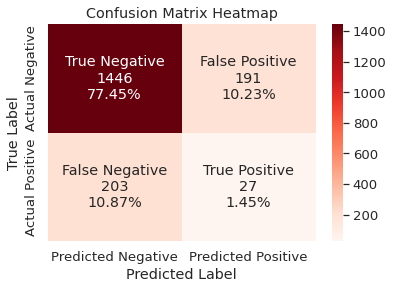

In [0]:
# Create seaborn heatmap
heatmap = sns.heatmap(confusion_matrix_values, annot=labels, fmt='', cmap='Reds', cbar=True,
                      xticklabels=['Predicted Negative', 'Predicted Positive'],
                      yticklabels=['Actual Negative', 'Actual Positive'])

# Set heatmap labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')

# Display the heatmap
plt.show()
